In [79]:
# Centralized imports for the full notebook workflow.
from pathlib import Path
import os
import re
from collections import Counter
from time import perf_counter

import clip
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn.functional as F

from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    brier_score_loss,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split

SEED = 42
print("Imports loaded. Seed set to", SEED)


Imports loaded. Seed set to 42


In [80]:
# Force project root (NOT notebooks/)
PROJECT_ROOT = Path.cwd().parent

IMAGES_DIR = PROJECT_ROOT / "data" / "fakeddit" / "images"
MANIFEST_PATH = PROJECT_ROOT / "data" / "fakeddit" / "downloaded_image_ids.csv"
BASE_TSV = PROJECT_ROOT / "data" / "fakeddit" / "multimodal_train.tsv"
PARQUET_PATH = PROJECT_ROOT / "data" / "fakeddit" / "df_clip_embeddings.parquet"

print("PROJECT_ROOT =", PROJECT_ROOT)
print("IMAGES_DIR =", IMAGES_DIR, "exists:", IMAGES_DIR.exists())
print("Num files in IMAGES_DIR =", len(list(IMAGES_DIR.glob("*"))))
print("BASE_TSV exists:", BASE_TSV.exists())
print("PARQUET exists:", PARQUET_PATH.exists())


PROJECT_ROOT = c:\Users\guyga\My Drive\MBD_Multimodal_Misinformation
IMAGES_DIR = c:\Users\guyga\My Drive\MBD_Multimodal_Misinformation\data\fakeddit\images exists: True
Num files in IMAGES_DIR = 10025
BASE_TSV exists: True
PARQUET exists: True


In [81]:
image_ids = [
    p.stem
    for p in IMAGES_DIR.iterdir()
    if p.suffix.lower() in [".jpg", ".png", ".jpeg"]
]

print("Recovered image count:", len(image_ids))

pd.DataFrame({"id": image_ids}).to_csv(MANIFEST_PATH, index=False)
print("Saved manifest at:", MANIFEST_PATH)


Recovered image count: 10025
Saved manifest at: c:\Users\guyga\My Drive\MBD_Multimodal_Misinformation\data\fakeddit\downloaded_image_ids.csv


In [82]:
# Runtime checks
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CLIP module loaded:", hasattr(clip, "load"))


Torch version: 2.9.1+cpu
CUDA available: False
CLIP module loaded: True


In [83]:


PROJECT_ROOT = Path.cwd().parent  
matches = list(PROJECT_ROOT.rglob("multimodal_train.tsv"))

print("Found:", len(matches))
for m in matches:
    print(m)


Found: 1
c:\Users\guyga\My Drive\MBD_Multimodal_Misinformation\data\fakeddit\multimodal_train.tsv


In [84]:


BASE_TSV = matches[0]   # assumes found >= 1
print("Using BASE_TSV:", BASE_TSV)

df_raw = pd.read_csv(BASE_TSV, sep="\t")
print("df_raw shape:", df_raw.shape)


Using BASE_TSV: c:\Users\guyga\My Drive\MBD_Multimodal_Misinformation\data\fakeddit\multimodal_train.tsv
df_raw shape: (564000, 16)


In [85]:

# Running inside .../notebooks, so project root is the parent directory
PROJECT_ROOT = Path.cwd().parent

# Load base multimodal-only train TSV (local path, not Colab)
BASE_TSV = PROJECT_ROOT / "data" / "fakeddit" / "multimodal_train.tsv"

print("Using BASE_TSV:", BASE_TSV)
df_raw = pd.read_csv(BASE_TSV, sep="\t")
print("df_raw shape (FULL TSV):", df_raw.shape)

# Keep only samples with text + image
df_raw = df_raw[
    df_raw["clean_title"].notna() &
    df_raw["image_url"].notna()
].reset_index(drop=True)

print("df_raw shape after filtering text+image:", df_raw.shape)

# Create 15k working subset (fixed seed)
df_15k = df_raw.sample(n=15000, random_state=42).reset_index(drop=True)
print("df_15k shape (WORKING SET):", df_15k.shape)


Using BASE_TSV: c:\Users\guyga\My Drive\MBD_Multimodal_Misinformation\data\fakeddit\multimodal_train.tsv
df_raw shape (FULL TSV): (564000, 16)
df_raw shape after filtering text+image: (562466, 16)
df_15k shape (WORKING SET): (15000, 16)


In [86]:

# Running inside /notebooks, so project root is the parent directory
PROJECT_ROOT = Path.cwd().parent

BASE_DIR = PROJECT_ROOT / "data" / "fakeddit"

IMAGES_DIR = BASE_DIR / "images"
MANIFEST_PATH = BASE_DIR / "downloaded_image_ids.csv"
TRAIN_TSV = BASE_DIR / "multimodal_train.tsv"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("Images dir exists:", IMAGES_DIR.exists())
print("Manifest exists:", MANIFEST_PATH.exists())
print("Train TSV exists:", TRAIN_TSV.exists())

PROJECT_ROOT: c:\Users\guyga\My Drive\MBD_Multimodal_Misinformation
Images dir exists: True
Manifest exists: True
Train TSV exists: True


In [87]:
# Build df_ready from saved artifacts
downloaded_ids = set(pd.read_csv(MANIFEST_PATH)["id"])

df_ready = df_15k[
    df_15k["id"].isin(downloaded_ids)
].reset_index(drop=True)

print("df_ready shape:", df_ready.shape)


df_ready shape: (10025, 16)


In [88]:
df_ready.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10025 entries, 0 to 10024
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   author                9505 non-null   object 
 1   clean_title           10025 non-null  object 
 2   created_utc           10025 non-null  float64
 3   domain                9959 non-null   object 
 4   hasImage              10025 non-null  bool   
 5   id                    10025 non-null  object 
 6   image_url             10025 non-null  object 
 7   linked_submission_id  66 non-null     object 
 8   num_comments          9959 non-null   float64
 9   score                 10025 non-null  int64  
 10  subreddit             10025 non-null  object 
 11  title                 10025 non-null  object 
 12  upvote_ratio          9959 non-null   float64
 13  2_way_label           10025 non-null  int64  
 14  3_way_label           10025 non-null  int64  
 15  6_way_label        

## Step 1: Dataset Coverage Checks
Confirm how much of the sampled dataset has downloadable images and usable labels before preprocessing.
This prevents spending time training on a subset with hidden coverage gaps.

In [89]:
total_sampled = len(df_15k) if "df_15k" in globals() else None
ready_count = len(df_ready)

print(f"Rows in df_ready: {ready_count}")
if total_sampled is not None and total_sampled > 0:
    coverage = ready_count / total_sampled
    print(f"Coverage vs sampled set: {coverage:.2%} ({ready_count}/{total_sampled})")

if "2_way_label" in df_ready.columns:
    print("\nLabel distribution in df_ready:")
    display(df_ready["2_way_label"].value_counts(dropna=False).rename("count").to_frame())


Rows in df_ready: 10025
Coverage vs sampled set: 66.83% (10025/15000)

Label distribution in df_ready:


,count
2_way_label,
1,5563
0,4462


## Step 2: Data Preprocessing
Prepare a training-ready table by selecting required columns, cleaning text, and validating null/length constraints.
The output of this step is the canonical dataframe used for EDA and modeling.

In [90]:

# Assumes df_ready already exists and has ~10,025 rows
print("Input shape:", df_ready.shape)

# Selects only the columns required for modeling.
df = df_ready[[
    "id",
    "clean_title",
    "2_way_label"
]].copy()

df.rename(columns={"2_way_label": "label"}, inplace=True)

# Cleans text with a simple routine that remains compatible with CLIP.
def clean_text(text):
    text = text.lower().strip()
    text = re.sub(r"http\S+", "", text)        # remove URLs
    text = re.sub(r"\s+", " ", text)           # normalize whitespace
    text = re.sub(r"[^\w\s]", "", text)        # remove punctuation
    return text

df["text"] = df["clean_title"].apply(clean_text)

# Removes empty or very short text entries.
df["text_len"] = df["text"].apply(len)

df = df[df["text_len"] >= 5].reset_index(drop=True)

# Runs quick sanity checks before training.
assert df["id"].isnull().sum() == 0
assert df["text"].isnull().sum() == 0
assert df["label"].isnull().sum() == 0

print("Final CLIP-ready shape:", df.shape)
print(df.head())
df

Input shape: (10025, 16)
Final CLIP-ready shape: (9979, 5)
       id                                  clean_title  label  \
0  2cdqb2   a terrifying and chocolatey cookie monster      0   
1  axhmr4  the synagogue cared for by muslims bbc reel      1   
2  b25ywe                     the flight of this plane      1   
3  2umqj8         mr butterface and his little brother      0   
4  1kog6d         this pylon looks like a sleeping owl      0   

                                          text  text_len  
0   a terrifying and chocolatey cookie monster        42  
1  the synagogue cared for by muslims bbc reel        43  
2                     the flight of this plane        24  
3         mr butterface and his little brother        36  
4         this pylon looks like a sleeping owl        36  


,id,clean_title,label,text,text_len
0,2cdqb2,a terrifying and chocolatey cookie monster,0,a terrifying and chocolatey cookie monster,42
1,axhmr4,the synagogue cared for by muslims bbc reel,1,the synagogue cared for by muslims bbc reel,43
2,b25ywe,the flight of this plane,1,the flight of this plane,24
3,2umqj8,mr butterface and his little brother,0,mr butterface and his little brother,36
4,1kog6d,this pylon looks like a sleeping owl,0,this pylon looks like a sleeping owl,36
...,...,...,...,...,...
9974,7h0wdm,girl licking a big chocolate popsicle,0,girl licking a big chocolate popsicle,37
9975,djfs8z,the pattern the grass made,1,the pattern the grass made,26
9976,5l3r3b,burnt up penis experiencing necrose nsfw,0,burnt up penis experiencing necrose nsfw,40
9977,ba7jmf,this supermarket built into the old city theat...,1,this supermarket built into the old city theat...,72


## Step 3: Exploratory Data Analysis
Review class balance, text-length behavior, duplicates, and top terms by class.
These checks help explain downstream model behavior and potential bias.

Dataframe shape: (9979, 5)

Missing values:


,missing_count
id,0
text,0
label,0
text_len,0



Label distribution (count):


,count
label,
0,4417
1,5562


Label distribution (proportion):


,proportion
label,
0,0.44263
1,0.55737



Text length summary:


,count,mean,std,min,25%,50%,75%,max
text_len,9979.0,50.939072,32.404333,5.0,28.0,45.0,66.0,294.0


Duplicate text rows: 31
Duplicate id rows: 0
Duplicate (id, text) rows: 0


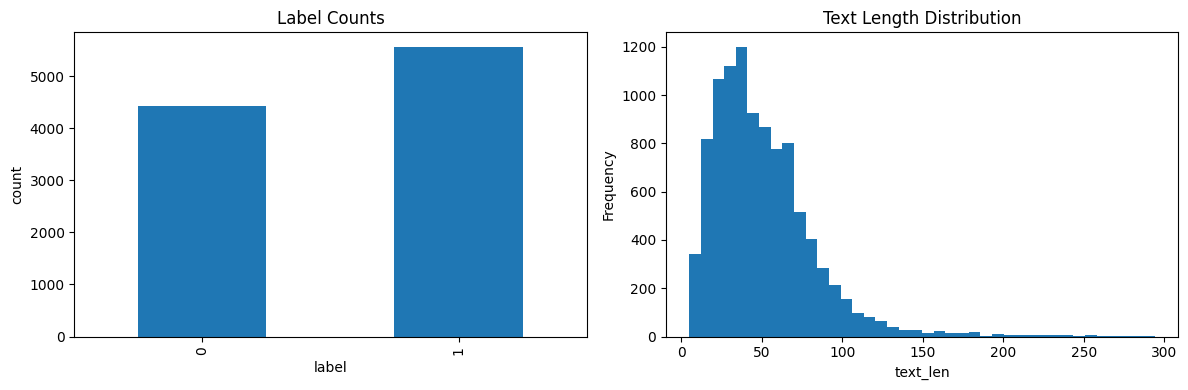


Top terms for label=0:
[('the', 1635), ('this', 512), ('and', 399), ('for', 321), ('with', 213), ('from', 191), ('you', 190), ('his', 189), ('that', 151), ('new', 131), ('like', 130), ('happy', 126), ('looks', 114), ('was', 114), ('first', 109)]

Top terms for label=1:
[('the', 1721), ('this', 1139), ('and', 519), ('for', 488), ('with', 462), ('from', 310), ('has', 268), ('that', 248), ('like', 210), ('after', 207), ('man', 199), ('dog', 189), ('his', 187), ('found', 184), ('out', 173)]


In [91]:

print("Dataframe shape:", df.shape)
print("\nMissing values:")
display(df[["id", "text", "label", "text_len"]].isna().sum().to_frame("missing_count"))

label_counts = df["label"].value_counts().sort_index()
label_props = df["label"].value_counts(normalize=True).sort_index()

print("\nLabel distribution (count):")
display(label_counts.rename("count").to_frame())
print("Label distribution (proportion):")
display(label_props.rename("proportion").to_frame())

print("\nText length summary:")
display(df["text_len"].describe().to_frame().T)

dup_text = int(df["text"].duplicated().sum())
dup_id = int(df["id"].duplicated().sum())
dup_pair = int(df.duplicated(subset=["id", "text"]).sum())
print(f"Duplicate text rows: {dup_text}")
print(f"Duplicate id rows: {dup_id}")
print(f"Duplicate (id, text) rows: {dup_pair}")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
label_counts.plot(kind="bar", ax=axes[0], title="Label Counts")
axes[0].set_xlabel("label")
axes[0].set_ylabel("count")
df["text_len"].plot(kind="hist", bins=40, ax=axes[1], title="Text Length Distribution")
axes[1].set_xlabel("text_len")
plt.tight_layout()
plt.show()

def top_terms_by_label(data, label_col="label", text_col="text", top_n=20):
    token_pattern = re.compile(r"\b[a-z]{3,}\b")
    out = {}
    for lab in sorted(data[label_col].unique()):
        tokens = []
        for txt in data.loc[data[label_col] == lab, text_col].astype(str):
            tokens.extend(token_pattern.findall(txt))
        out[lab] = Counter(tokens).most_common(top_n)
    return out

term_stats = top_terms_by_label(df, top_n=15)
for lab, terms in term_stats.items():
    print(f"\nTop terms for label={lab}:")
    print(terms)


In [92]:


# Running inside /notebooks, move to project root
PROJECT_ROOT = Path.cwd().parent

PARQUET_PATH = PROJECT_ROOT / "data" / "fakeddit" / "df_clip_embeddings.parquet"

print("Using PARQUET_PATH:", PARQUET_PATH)
print("Exists:", PARQUET_PATH.exists())

df_emb = pd.read_parquet(PARQUET_PATH)

print("Loaded embeddings shape:", df_emb.shape)

Using PARQUET_PATH: c:\Users\guyga\My Drive\MBD_Multimodal_Misinformation\data\fakeddit\df_clip_embeddings.parquet
Exists: True
Loaded embeddings shape: (9979, 4)


## Step 4: Feature Engineering
Construct multimodal features from CLIP embeddings:
- cosine similarity
- absolute embedding difference
- embedding concatenation

In [93]:
# Stack embeddings into arrays
img_embs = np.vstack(df_emb["image_emb"].values)
txt_embs = np.vstack(df_emb["text_emb"].values)

# 1) Cosine similarity
cos_sim = np.array([
    cosine_similarity(
        img_embs[i].reshape(1, -1),
        txt_embs[i].reshape(1, -1)
    )[0, 0]
    for i in range(len(df_emb))
]).reshape(-1, 1)

# 2) Absolute difference
abs_diff = np.abs(img_embs - txt_embs)

# 3) Concatenation
concat = np.hstack([img_embs, txt_embs])

# Final feature matrix
X = np.hstack([cos_sim, abs_diff, concat])
y = df_emb["label"].values

print("Feature matrix shape:", X.shape)


Feature matrix shape: (9979, 1537)


## Step 5: Train/Test Split
Create a stratified split so label proportions stay stable across train and test sets.

In [94]:
row_idx = np.arange(len(y))

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X,
    y,
    row_idx,
    test_size=0.25,
    random_state=SEED,
    stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Index split:", len(idx_train), len(idx_test))


Train: (7484, 1537) Test: (2495, 1537)
Index split: 7484 2495


## Step 6: Post-Split Validation
Verify class-balance consistency and check for ID overlap across splits to reduce leakage risk.

In [95]:
train_label_dist = pd.Series(y_train).value_counts(normalize=True).sort_index()
test_label_dist = pd.Series(y_test).value_counts(normalize=True).sort_index()

print("Train label distribution (proportion):")
display(train_label_dist.rename("train_prop").to_frame())

print("Test label distribution (proportion):")
display(test_label_dist.rename("test_prop").to_frame())

dist_compare = pd.concat([
    train_label_dist.rename("train_prop"),
    test_label_dist.rename("test_prop"),
], axis=1).fillna(0)
dist_compare["abs_diff"] = (dist_compare["train_prop"] - dist_compare["test_prop"]).abs()
print("Label distribution gap (absolute difference):")
display(dist_compare)

# Leakage check on ids when available.
if "df_emb" in globals() and "id" in df_emb.columns:
    train_ids = set(df_emb.iloc[idx_train]["id"])
    test_ids = set(df_emb.iloc[idx_test]["id"])
    overlap = train_ids.intersection(test_ids)
    print(f"Train IDs: {len(train_ids)} | Test IDs: {len(test_ids)} | Overlap: {len(overlap)}")
    if overlap:
        print("Warning: overlapping IDs found between train and test splits.")
else:
    print("ID leakage check skipped (df_emb with id column not available).")


Train label distribution (proportion):


,train_prop
0,0.442678
1,0.557322


Test label distribution (proportion):


,test_prop
0,0.442485
1,0.557515


Label distribution gap (absolute difference):


,train_prop,test_prop,abs_diff
0,0.442678,0.442485,0.000193
1,0.557322,0.557515,0.000193


Train IDs: 7484 | Test IDs: 2495 | Overlap: 0


## Step 7: Baseline Model Training
Train Logistic Regression as the baseline classifier on the engineered feature space.

In [96]:
clf = LogisticRegression(
    max_iter=2000,
    n_jobs=-1,
    class_weight="balanced"
)

clf.fit(X_train, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,2000
,multi_class,'deprecated'


## Step 8: Baseline Evaluation
Measure baseline performance using ROC-AUC and a full classification report.

In [97]:
y_probs = clf.predict_proba(X_test)[:, 1]
y_pred = clf.predict(X_test)

print("ROC-AUC:", roc_auc_score(y_test, y_probs))
print("\nClassification report:\n")
print(classification_report(y_test, y_pred))


ROC-AUC: 0.9237417820564916

Classification report:

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      1104
           1       0.87      0.85      0.86      1391

    accuracy                           0.85      2495
   macro avg       0.84      0.85      0.85      2495
weighted avg       0.85      0.85      0.85      2495



## Step 9: Alternative Models and Boosting
Benchmark tree-based and boosting alternatives against the logistic baseline.
This step helps identify whether non-linear learners improve discrimination.

In [98]:
# Cache settings for faster experimentation.
FORCE_RETRAIN = False
CACHE_DIR = PROJECT_ROOT / "artifacts"
CACHE_DIR.mkdir(parents=True, exist_ok=True)
CACHE_FILE = CACHE_DIR / "model_comparison_cache.joblib"

# A lightweight fingerprint so cache is invalidated when split/data changes.
cache_fingerprint = {
    "x_train_shape": tuple(X_train.shape),
    "x_test_shape": tuple(X_test.shape),
    "y_train_sum": int(np.sum(y_train)),
    "y_test_sum": int(np.sum(y_test)),
    "seed": SEED,
}

use_cache = CACHE_FILE.exists() and not FORCE_RETRAIN

if use_cache:
    cached = joblib.load(CACHE_FILE)
    if cached.get("fingerprint") == cache_fingerprint:
        print(f"Loaded cached benchmark from: {CACHE_FILE}")
        results_df = cached["results_df"]
        trained_models = cached["trained_models"]
        best_model_name = cached["best_model_name"]
        best_model = trained_models[best_model_name]
    else:
        print("Cache fingerprint mismatch. Re-training models...")
        use_cache = False

if not use_cache:
    # Include the existing logistic model as baseline.
    candidate_models = {
        "Logistic Regression (baseline)": clf,
        "Random Forest": RandomForestClassifier(
            n_estimators=250,
            class_weight="balanced",
            random_state=SEED,
            n_jobs=-1,
        ),
        "Gradient Boosting": GradientBoostingClassifier(random_state=SEED),
        "HistGradientBoosting": HistGradientBoostingClassifier(random_state=SEED),
        "AdaBoost": AdaBoostClassifier(
            n_estimators=200,
            learning_rate=0.05,
            random_state=SEED,
        ),
    }

    comparison_rows = []
    trained_models = {"Logistic Regression (baseline)": clf}

    for model_name, model in candidate_models.items():
        start = perf_counter()
        if model_name != "Logistic Regression (baseline)":
            model.fit(X_train, y_train)
            trained_models[model_name] = model
        fit_time_s = perf_counter() - start

        y_pred = model.predict(X_test)
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test)[:, 1]
        elif hasattr(model, "decision_function"):
            y_score = model.decision_function(X_test)
        else:
            y_score = y_pred

        comparison_rows.append({
            "Model": model_name,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred, zero_division=0),
            "Recall": recall_score(y_test, y_pred, zero_division=0),
            "F1": f1_score(y_test, y_pred, zero_division=0),
            "ROC-AUC": roc_auc_score(y_test, y_score),
            "Fit time (s)": fit_time_s,
        })

    results_df = pd.DataFrame(comparison_rows).sort_values("ROC-AUC", ascending=False)
    best_row = results_df.iloc[0]
    best_model_name = best_row["Model"]
    best_model = trained_models[best_model_name]

    joblib.dump(
        {
            "fingerprint": cache_fingerprint,
            "results_df": results_df,
            "trained_models": trained_models,
            "best_model_name": best_model_name,
        },
        CACHE_FILE,
    )
    print(f"Saved benchmark cache to: {CACHE_FILE}")

display(
    results_df.style.format(
        {
            "Accuracy": "{:.4f}",
            "Precision": "{:.4f}",
            "Recall": "{:.4f}",
            "F1": "{:.4f}",
            "ROC-AUC": "{:.4f}",
            "Fit time (s)": "{:.2f}",
        }
    )
)

print(f"Best model by ROC-AUC: {best_model_name}")
print(f"Best ROC-AUC: {float(results_df.iloc[0]['ROC-AUC']):.4f}")


Loaded cached benchmark from: c:\Users\guyga\My Drive\MBD_Multimodal_Misinformation\artifacts\model_comparison_cache.joblib


,Model,Accuracy,Precision,Recall,F1,ROC-AUC,Fit time (s)
0,Logistic Regression (baseline),0.8473,0.8719,0.8512,0.8614,0.9237,0.00
3,HistGradientBoosting,0.8333,0.8392,0.8670,0.8529,0.9060,29.92
2,Gradient Boosting,0.8076,0.8170,0.8440,0.8303,0.8920,1006.60
1,Random Forest,0.7743,0.7594,0.8713,0.8115,0.8681,10.89
4,AdaBoost,0.7515,0.7617,0.8066,0.7835,0.8275,800.55


Best model by ROC-AUC: Logistic Regression (baseline)
Best ROC-AUC: 0.9237


## Step 10: Final Validation and Calibration
Run cross-validated stability checks for Logistic Regression and test probability calibration.
Use this step to choose a deployable final model with reliable confidence scores.

In [99]:
# Cross-validated stability check for Logistic Regression
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
cv_logreg = LogisticRegression(max_iter=2000, n_jobs=-1, class_weight="balanced")

cv_auc_scores = cross_val_score(cv_logreg, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_f1_scores = cross_val_score(cv_logreg, X, y, cv=cv, scoring="f1", n_jobs=-1)

print("LogReg 5-fold CV ROC-AUC:", np.round(cv_auc_scores, 4))
print(f"Mean ROC-AUC: {cv_auc_scores.mean():.4f} +/- {cv_auc_scores.std():.4f}")
print("LogReg 5-fold CV F1:", np.round(cv_f1_scores, 4))
print(f"Mean F1: {cv_f1_scores.mean():.4f} +/- {cv_f1_scores.std():.4f}")

# Probability calibration on top of Logistic Regression
calibrated_clf = CalibratedClassifierCV(
    estimator=LogisticRegression(max_iter=2000, n_jobs=-1, class_weight="balanced"),
    method="sigmoid",
    cv=5,
)
calibrated_clf.fit(X_train, y_train)

y_prob_base = clf.predict_proba(X_test)[:, 1]
y_prob_cal = calibrated_clf.predict_proba(X_test)[:, 1]

a_uc_base = roc_auc_score(y_test, y_prob_base)
a_uc_cal = roc_auc_score(y_test, y_prob_cal)
brier_base = brier_score_loss(y_test, y_prob_base)
brier_cal = brier_score_loss(y_test, y_prob_cal)

print(f"Base LogReg test ROC-AUC: {a_uc_base:.4f}")
print(f"Calibrated LogReg test ROC-AUC: {a_uc_cal:.4f}")
print(f"Base LogReg Brier score: {brier_base:.4f}")
print(f"Calibrated LogReg Brier score: {brier_cal:.4f}")

# Select final deploy model:
# Prefer calibrated model when ROC-AUC is not worse and Brier score improves.
if (a_uc_cal >= a_uc_base - 1e-6) and (brier_cal <= brier_base):
    final_model = calibrated_clf
    final_model_name = "LogisticRegression + CalibratedClassifierCV(sigmoid)"
else:
    final_model = clf
    final_model_name = "LogisticRegression"

print(f"Selected final model for deployment: {final_model_name}")


LogReg 5-fold CV ROC-AUC: [0.9282 0.9326 0.9222 0.9312 0.9361]
Mean ROC-AUC: 0.9301 +/- 0.0047
LogReg 5-fold CV F1: [0.8705 0.8661 0.8582 0.8687 0.881 ]
Mean F1: 0.8689 +/- 0.0074
Base LogReg test ROC-AUC: 0.9237
Calibrated LogReg test ROC-AUC: 0.9223
Base LogReg Brier score: 0.1103
Calibrated LogReg Brier score: 0.1094
Selected final model for deployment: LogisticRegression


## Step 11: Save Trained Model
Persist the selected classifier artifact for deployment and local app inference.

In [100]:
# Running inside /notebooks, so project root is the parent directory
PROJECT_ROOT = Path.cwd().parent

DEMO_DIR = PROJECT_ROOT / "demo"
DEMO_DIR.mkdir(parents=True, exist_ok=True)

MODEL_PATH = DEMO_DIR / "model.pkl"
model_to_save = (
    final_model if "final_model" in globals() else
    best_model if "best_model" in globals() else
    clf
)

joblib.dump(model_to_save, MODEL_PATH)

print("Model saved at:", MODEL_PATH)
print("Saved model type:", type(model_to_save).__name__)
print("Saved model label:", globals().get("final_model_name", globals().get("best_model_name", "LogisticRegression")))


Model saved at: c:\Users\guyga\My Drive\MBD_Multimodal_Misinformation\demo\model.pkl
Saved model type: LogisticRegression
Saved model label: LogisticRegression


In [101]:
root = Path(".").resolve()  # current notebook working directory
print(f"Root: {root}\n")

for path in sorted(root.rglob("*")):
    depth = len(path.relative_to(root).parts) - 1
    indent = "    " * depth
    marker = "[D]" if path.is_dir() else "[F]"
    print(f"{indent}{marker} {path.name}")


Root: C:\Users\guyga\My Drive\MBD_Multimodal_Misinformation\notebooks

[F] MBD_Technical_Group.ipynb


## Step 12: Deployment Smoke Test
Load the saved model artifact to confirm it can be deserialized successfully for Streamlit usage.

In [102]:
model = joblib.load("../demo/model.pkl")
